<a href="https://colab.research.google.com/github/flydragon2018/Analytics_Vidhya/blob/master/handwriting_recognition_sep26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Sep 26 13:40:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')##,force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/"My Drive"/handwriting/handWriting.zip 

In [4]:
!cp -rf /content/drive/"My Drive"/handwriting/best_hw_model.ckpt .

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [2]:
pwd

'/content'

In [3]:
ls

best_hw_model.ckpt/  mymodel092613.h5  test/   train.csv
drive/               sample_data/      train/


In [4]:
train = pd.read_csv('train.csv')
#valid=train.sample(frac=0.1) 

maxlabel=int(train["label"].str.len().max())
print(maxlabel)

34


In [5]:
train.head()

,filename,label
0,0,BALTHAZAR
1,1,SIMON
2,2,BENES
3,3,LA LOVE
4,4,DAPHNE


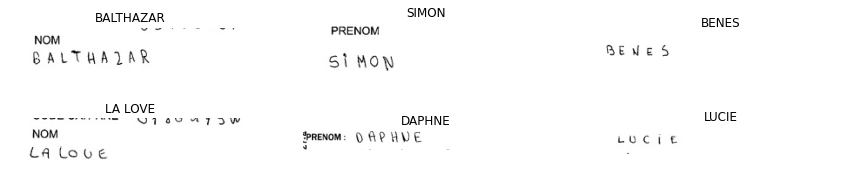

In [6]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train/'+str(i)+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [7]:
print("Number of NaNs in train set      : ", train['label'].isnull().sum())
 


Number of NaNs in train set      :  643


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372331 entries, 0 to 372330
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  372331 non-null  int64 
 1   label     371688 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.7+ MB


In [9]:
train.dropna(axis=0, inplace=True)
 

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371688 entries, 0 to 372330
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  371688 non-null  int64 
 1   label     371688 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.5+ MB


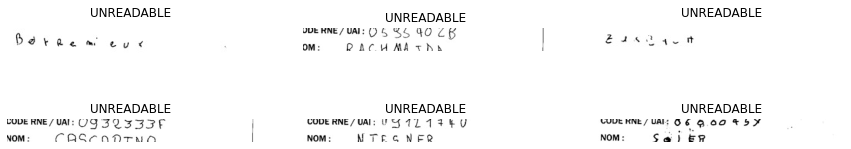

In [11]:
unreadable = train[train['label'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir =img_dir = 'train/'+str(unreadable.loc[i,"filename"])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [12]:
train = train[train['label'] != 'UNREADABLE']
 

In [13]:
train['label'] = train['label'].str.upper()
 

In [14]:
train.reset_index(inplace = True, drop=True) 
 

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371574 entries, 0 to 371573
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  371574 non-null  int64 
 1   label     371574 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.7+ MB


In [16]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [17]:
#train_size = 40000
#valid_size= 4000

train_size = 42000
valid_size= 1000

print(train_size,valid_size)

42000 1000


In [18]:
#first round 
#start_i=0
#start_i=train_size
#start_i=160000
#start_i=200000
start_i=160000

In [19]:
train_x = []

for i in range(start_i,(start_i+train_size),1):
    img_dir = 'train/'+str(train.loc[i, 'filename'])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [20]:
##valid_x =train_x[0:valid_size]

In [21]:

valid_x =[]

for i in range(start_i+train_size,start_i+train_size+valid_size,1):
    img_dir = 'train/'+str(train.loc[i, 'filename'])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)


In [22]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [23]:
alphabets = u" ABCDEFGHIJKLMNOPQRSTUVWXYZ-'"
 
max_str_len = int(maxlabel) # max length of input labels 34
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        #label_num.append(alphabets.find(ch))
        n=alphabets.find(ch)
        if n==-1:
          n=0  ## simply to avoid error of All labels must be nonnegative integers
        label_num.append(n)
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [24]:
name = 'DRAGON'
print(name, '\n',label_to_num(name))

DRAGON 
 [ 4 18  1  7 15 14]


In [25]:
#train_y = np.ones([train_size, max_str_len]) * -1
## modified on sept 18
train_y = np.zeros([train_size, max_str_len])*1  
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(str(train.loc[i+start_i, 'label']))
    train_y[i, 0:len(str(train.loc[i+start_i, 'label']))]= label_to_num(str(train.loc[i+start_i, 'label']))    


In [26]:
#valid_y = np.ones([valid_size, max_str_len]) * -1

valid_y = np.zeros([valid_size, max_str_len])*1 

valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(str(train.loc[i+start_i+train_size, 'label']))
    valid_y[i, 0:len(str(train.loc[i+start_i+train_size, 'label']))]= label_to_num(str(train.loc[i+start_i+train_size, 'label']))  

In [27]:
'''
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()
'''


"\ninput_data = Input(shape=(256, 64, 1), name='input')\n\ninner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  \ninner = BatchNormalization()(inner)\ninner = Activation('relu')(inner)\ninner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)\n\ninner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)\ninner = BatchNormalization()(inner)\ninner = Activation('relu')(inner)\ninner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)\ninner = Dropout(0.3)(inner)\n\ninner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)\ninner = BatchNormalization()(inner)\ninner = Activation('relu')(inner)\ninner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)\ninner = Dropout(0.3)(inner)\n\n# CNN to RNN\ninner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)\ninner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)\n\n## RNN\

In [28]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.2)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.2)(inner)

inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)
inner = Dropout(0.2)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)      

In [29]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [30]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [31]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

In [32]:
#!mkdir -p best_hw_model.ckpt

In [33]:
# Define ModelCheckpoint callback
checkpoint_path = "best_hw_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, monitor='val_accuracy', verbose=1, save_weights_only=False,
   histogram_freq=10, 
   # Save weights, every epoch.
   # save_freq='epoch',
   mode='auto',save_best_only=True)

# Train the model
#model.fit(x_train, y_train, epochs=Epochs,validation_data=(x_test, y_test), callbacks=[checkpoint_callback])


In [34]:
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),epochs=360, batch_size=128,callbacks=[checkpoint_callback])

328/329 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9904
Epoch 00355: val_accuracy did not improve from 0.81000
329/329 [==============================] - 49s 150ms/step - loss: 0.0273 - accuracy: 0.9904 - val_loss: 3.1567 - val_accuracy: 0.7880
Epoch 356/360
328/329 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9897
Epoch 00356: val_accuracy did not improve from 0.81000
329/329 [==============================] - 49s 150ms/step - loss: 0.0275 - accuracy: 0.9897 - val_loss: 3.1292 - val_accuracy: 0.7990
Epoch 357/360
328/329 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9860
Epoch 00357: val_accuracy did not improve from 0.81000
329/329 [==============================] - 49s 150ms/step - loss: 0.0364 - accuracy: 0.9860 - val_loss: 3.1790 - val_accuracy: 0.7930
Epoch 358/360
328/329 [============================>.] - ETA: 0s - loss: 0.0407 - accuracy: 0.9834
Epoch 00358: val_accuracy did not improve from 0.81

In [35]:
from datetime import datetime
dt=datetime.now()
model.save("./mymodel{}.h5".format(dt.strftime("%m%d%H")))
model_final.save("./mymodelfinal{}.h5".format(dt.strftime("%m%d%H")))

In [36]:
'''
# load the model
from keras.models import Sequential, load_model
from numpy.testing import assert_allclose

 
x_train = train_x[:100]
y_train = train_y[:100]


new_model = load_model("./mymodel.h5",compile=False)
new_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

##assert_allclose(model.predict(x_train), new_model.predict(x_train))
##does not need this assert!!

# fit the model
# Define ModelCheckpoint callback
checkpoint_path = "best_hw_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, monitor='val_accuracy', verbose=1, save_weights_only=False,
   # Save weights, every epoch.
   # save_freq='epoch',
   mode='auto',save_best_only=True)

#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]
new_model.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, \
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),epochs=120, batch_size=128,callbacks=[checkpoint_callback])

'''

'\n# load the model\nfrom keras.models import Sequential, load_model\nfrom numpy.testing import assert_allclose\n\n \nx_train = train_x[:100]\ny_train = train_y[:100]\n\n\nnew_model = load_model("./mymodel.h5",compile=False)\nnew_model.compile(loss={\'ctc\': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001), metrics=[\'accuracy\'])\n\n##assert_allclose(model.predict(x_train), new_model.predict(x_train))\n##does not need this assert!!\n\n# fit the model\n# Define ModelCheckpoint callback\ncheckpoint_path = "best_hw_model.ckpt"\ncheckpoint_dir = os.path.dirname(checkpoint_path)\ncheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(\n   checkpoint_path, monitor=\'val_accuracy\', verbose=1, save_weights_only=False,\n   # Save weights, every epoch.\n   # save_freq=\'epoch\',\n   mode=\'auto\',save_best_only=True)\n\n#checkpoint = ModelCheckpoint(filepath, monitor=\'loss\', verbose=1, save_best_only=True, mode=\'min\')\n#callbacks_list = [checkpoint]\nnew_model.fit(x=[train_x, 

In [37]:
## new_model.save("./mynewmodel.h5")

In [38]:
'''

# Custom Metric (without external parameters)
def metric_no_params(yTrue,yPred):
  return tf.keras.metrics.sparse_categorical_accuracy(yTrue, yPred)

# Create a basic model instance
model = create_model()

# Compile the model
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy',metric_no_params]) 

# define history callback (you can use it to access some parameters under it)
history = model.fit(x_train, y_train, epochs = Epochs, verbose=1,batch_size=128)

loss, acc, acc_spa  = model.evaluate(x_test, y_test, verbose=10) 
print("Original model, accuracy: {:5.2f}%".format(100*acc))

# Loading the saved model and testing the performance (tf format)
loaded_model_tf = tf.keras.models.load_model('MyModel_tf',custom_objects={'MyLoss_layer':MyLoss_layer()}) # 

# Evaluate the loaded model after loading weights from tf 
loss, acc_tf = loaded_model_tf.evaluate(x_test, y_test, verbose=1)
print("Loaded model (tf), loss:{:5.2f} and accuracy: {:5.2f}% ".format(loss, 100*acc_tf))

# Loading the saved model and testing the performance (h5 format)
loaded_model_h5 = tf.keras.models.load_model('MyModel_h5', custom_objects={'metric_no_params':metric_no_params})


# Evaluate the loaded model after loading weights from h5 
loss, acc_h5, acc_h5_cust = loaded_model_h5.evaluate(x_test, y_test, verbose=1)
print("Loaded model (h5), accuracy: {:5.2f}%".format(100*acc_h5))

'''

'\n\n# Custom Metric (without external parameters)\ndef metric_no_params(yTrue,yPred):\n  return tf.keras.metrics.sparse_categorical_accuracy(yTrue, yPred)\n\n# Create a basic model instance\nmodel = create_model()\n\n# Compile the model\nmodel.compile(optimizer=\'adam\',\n            loss=\'sparse_categorical_crossentropy\',\n            metrics=[\'sparse_categorical_accuracy\',metric_no_params]) \n\n# define history callback (you can use it to access some parameters under it)\nhistory = model.fit(x_train, y_train, epochs = Epochs, verbose=1,batch_size=128)\n\nloss, acc, acc_spa  = model.evaluate(x_test, y_test, verbose=10) \nprint("Original model, accuracy: {:5.2f}%".format(100*acc))\n\n# Loading the saved model and testing the performance (tf format)\nloaded_model_tf = tf.keras.models.load_model(\'MyModel_tf\',custom_objects={\'MyLoss_layer\':MyLoss_layer()}) # \n\n# Evaluate the loaded model after loading weights from tf \nloss, acc_tf = loaded_model_tf.evaluate(x_test, y_test, ver

In [39]:
'''
# Define ModelCheckpoint callback
checkpoint_path = "best_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, monitor='val_acc', verbose=1, save_weights_only=False,
   # Save weights, every epoch.
   # save_freq='epoch',
   mode='auto',save_best_only=True)

# Train the model
model.fit(x_train, y_train, epochs=Epochs,validation_data=(x_test, y_test), callbacks=[checkpoint_callback])
'''

'\n# Define ModelCheckpoint callback\ncheckpoint_path = "best_model.ckpt"\ncheckpoint_dir = os.path.dirname(checkpoint_path)\ncheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(\n   checkpoint_path, monitor=\'val_acc\', verbose=1, save_weights_only=False,\n   # Save weights, every epoch.\n   # save_freq=\'epoch\',\n   mode=\'auto\',save_best_only=True)\n\n# Train the model\nmodel.fit(x_train, y_train, epochs=Epochs,validation_data=(x_test, y_test), callbacks=[checkpoint_callback])\n'

In [40]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [41]:
y_true = train.loc[start_i+train_size:start_i+train_size+valid_size,'label']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i+start_i+train_size]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))


Correct characters predicted : 91.09%
Correct words predicted      : 79.40%


In [42]:
!cp *.h5  /content/drive/"My Drive"/handwriting

In [43]:
test = os.listdir('test')
testnum=len(test)

sub=[]
for i in range(testnum):
    
    img_dir = 'test/'+test[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
       
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    #print(decoded)
    sub.append([test[i][:-4],num_to_label(decoded[0])])
    print(i,test[i][:-4],num_to_label(decoded[0]) )
    
    #if i==10:
    #  break

df=pd.DataFrame(sub)
from datetime import datetime
dt=datetime.now()
df.to_csv("hw_{}_v3_sub.csv".format(dt.strftime("%m%d%H")),index=None,header=None)

Streaming output truncated to the last 5000 lines.
36371 34795 MATHILDE
36372 35538 PHILIPPE
36373 20755 ARAZ
36374 31602 ANGEL
36375 37926 BAPTISTE
36376 8248 TEBEKA
36377 35566 NICOLAS
36378 37246 BOUSIE
36379 19848 ROBIN
36380 24965 BECHTOLD
36381 20743 LACROIX
36382 32973 YASSINE
36383 26485 THEO
36384 17407 DE DALMAS
36385 11699 IDRISS
36386 12862 SPIESSER
36387 18162 MILLY
36388 35734 CARBON
36389 14596 BODOT
36390 17164 SANFILIPPO
36391 28697 BERTIN
36392 31982 THEODOME
36393 35954 SEGOLENE
36394 18818 MELIANI
36395 14209 INES
36396 9085 DWAKUNANI
36397 11036 AGNES
36398 18017 SABIN
36399 30835 NOELINE
36400 26920 ZACHARY
36401 5563 IEZELIN
36402 21684 LIOUX
36403 20115 THEO
36404 14443 FABRIER
36405 9235 PELERIN
36406 19495 MHEUILLET
36407 27360 KOUENEIN
36408 10340 ANTOINE
36409 40511 TRICHARD
36410 27122 SAVARESSE
36411 32454 EMMA
36412 1090 JOSHUA
36413 37128 CLEO
36414 6237 CLARA
36415 23419 RECOULES
36416 28029 DE SOUSA PE
36417 22005 SEBAIBI
36418 10964 MANON
36419 24824 

In [44]:
!cp *.csv /content/drive/"My Drive"/handwriting

In [45]:
!  cp -rf  /content/best_hw_model.ckpt  /content/drive/"My Drive"/handwriting